# Import Dependencies

In [3]:
import sys
sys.path.append('..')
import dependencies
import soft_dependencies
import matplotlib.pyplot as plt

Python Version 3.9.12 (main, Jun  1 2022, 06:36:29) 
[Clang 12.0.0 ]
Numpy Version 1.22.2
Scipy Version 1.7.3
Sklearn Version 1.0.2
Matplotlib Version 3.5.1
Pandas Version 1.4.2
Line Profiler Version 3.3.1
Memory Profiler Version 0.58.0


In [10]:
from Scripts.generate_data import generate_Ys
from Scripts.scBiGLasso import scBiGLasso
from Scripts.anBiGLasso import anBiGLasso
from Scripts.antGLasso import antGLasso
from Scripts.EiGLasso import EiGLasso
from Scripts.TeraLasso import TeraLasso

In [12]:
import numpy as np

# For timing results
import timeit

# For colorblind palette creation
from cycler import cycler

In [24]:
import line_profiler
%load_ext line_profiler

In [6]:
%load_ext autoreload
%autoreload 2

# Time scBiGLasso and anBiGLasso
**Note:**

'Easy' data comes from precision matrices generated from an
inverse Wishart distribution with many degrees of freedom.
Empirically, scBiGLasso converges very quickly.

'Hard' data comes from precision amtrices generated from an
inverse Wishart distribution with minimal degrees of freedom.
Empirically, scBiGLasso takes a long time to converge.

In [7]:
def generate_timing_graph(
    sizes,
    attempts, 
    m,
    df_scale,
    include_sc=True,
    include_eig=True,
    verbose=False
):
    if include_sc:
        times_sc = []
    times_an = []
    if include_eig:
        times_eig = []
    for size in sizes:
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        times_an.append(0)
        if include_eig:
            times_eig.append(0)
        _, _, Ys = generate_Ys(
            m=m,
            n=(n:=size),
            p=(p:=size),
            expected_nonzero_psi=n**2 / 5,
            expected_nonzero_theta=p**2 / 5,
            structure="Kronecker Sum",
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_anBiGLasso():
            anBiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                B_approx_iters = 10
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
        timer = timeit.Timer(time_anBiGLasso)
        times_an[-1] = timer.timeit(attempts) / attempts
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
        if verbose:
            if include_sc:
                print(
                    f"\tSc : {times_sc[-1]} Seconds"
                    + f"\n\tAn : {times_an[-1]} Seconds"
                    + (f"\n\tEig: {times_eig[-1]} Seconds" if include_eig else "")
                )
            else:
                print(
                    f"\tAn : {times_an[-1]} Seconds"
                    + (f"\n\tEig: {times_eig[-1]} Seconds" if include_eig else "")
                )
    if include_sc and include_eig:
        return times_sc, times_an, times_eig
    elif include_sc:
        return times_sc, times_an
    elif include_eig:
        return times_an, times_eig
    else:
        return times_an

### Large Sample

In [16]:
attempts = 10
print("Times on an 'easy' distribution")
sizes_for_easy = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sc_easy, an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=100,
    verbose=True
)
print("Times on a 'hard' distribution")
sizes_for_hard = [10, 20, 30, 40, 50]
sc_hard, an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=100,
    verbose=True
)

Times on an 'easy' distribution
Starting size=10
	Sc : 0.025689033300022857 Seconds
	An : 0.001062945900048362 Seconds
	Eig: 0.008558258300035959 Seconds
Starting size=20
	Sc : 0.042799695899975634 Seconds
	An : 0.0019620041000052877 Seconds
	Eig: 0.00343000419998134 Seconds
Starting size=30
	Sc : 0.06817909159999544 Seconds
	An : 0.0036453708000408367 Seconds
	Eig: 0.005485591699925863 Seconds
Starting size=40
	Sc : 0.11240949160001037 Seconds
	An : 0.007017808399996284 Seconds
	Eig: 0.009582637499988778 Seconds
Starting size=50
	Sc : 0.14808728329999213 Seconds
	An : 0.010451825000018289 Seconds
	Eig: 0.016570770899943455 Seconds
Starting size=60
	Sc : 0.1997614040999906 Seconds
	An : 0.01537568329995338 Seconds
	Eig: 0.022858274999998686 Seconds
Starting size=70
	Sc : 0.24127513339999496 Seconds
	An : 0.029160787500040898 Seconds
	Eig: 0.03076984999997876 Seconds
Starting size=80
	Sc : 0.314731912499974 Seconds
	An : 0.036802370900022655 Seconds
	Eig: 0.040576241700000536 Seconds
St

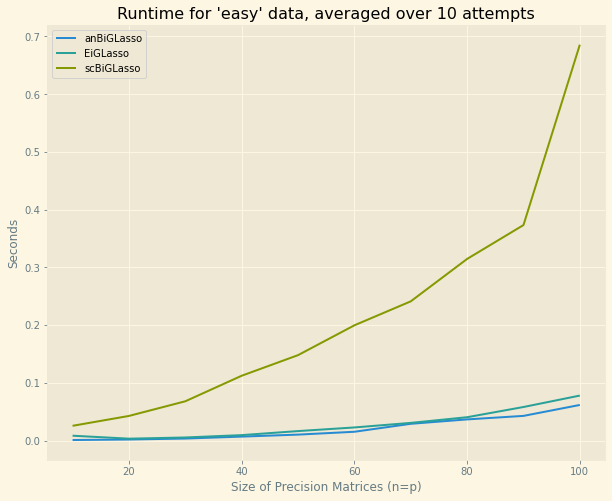

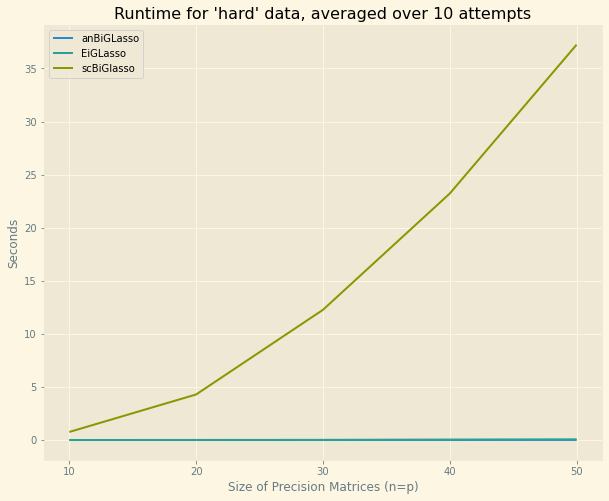

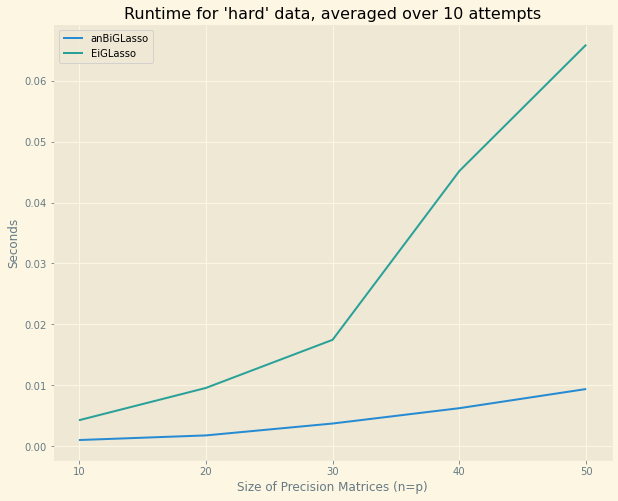

In [17]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.plot(sizes_for_easy, sc_easy, label='scBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Large Sample')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.plot(sizes_for_hard, sc_hard, label='scBiGlasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_xticks([10, 20, 30, 40, 50])
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Large Sample')
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        ax3.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax3.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_xticks([10, 20, 30, 40, 50])
        ax3.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax3.legend()
        fig3.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data No scBiGLasso Large Sample'
        )

### Small Sample

In [10]:
print("Times on an 'easy' distribution")
sizes_for_easy = [10, 20, 30, 40, 50]
sc_easy, an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=1,
    verbose=True
)
print("Times on a 'hard' distribution")
sizes_for_hard = [10, 20, 30, 40, 50]
sc_hard, an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True
)

Times on an 'easy' distribution
Starting size=10
	Sc : 1.5637737749999814 Seconds
	An : 0.0010289208000358486 Seconds
	Eig: 0.01093206669997926 Seconds
Starting size=20
	Sc : 15.327966591699987 Seconds
	An : 0.0019276375000117697 Seconds
	Eig: 0.02462910419999389 Seconds
Starting size=30
	Sc : 15.987220549999984 Seconds
	An : 0.037519162499984306 Seconds
	Eig: 0.06454114590001155 Seconds
Starting size=40
	Sc : 32.795254287499986 Seconds
	An : 0.003429362499991839 Seconds
	Eig: 0.12917245420003381 Seconds
Starting size=50
	Sc : 38.14393277920003 Seconds
	An : 0.005438541600051394 Seconds
	Eig: 0.17250978749998466 Seconds
Times on a 'hard' distribution
Starting size=10
	Sc : 0.6410062083999947 Seconds
	An : 0.0010276459000124305 Seconds
	Eig: 0.05397009590005837 Seconds
Starting size=20
	Sc : 2.739221658399947 Seconds
	An : 0.0019677999999657913 Seconds
	Eig: 0.2397458125000412 Seconds
Starting size=30
	Sc : 6.497756287500033 Seconds
	An : 0.0023629708000044046 Seconds
	Eig: 0.6951139290

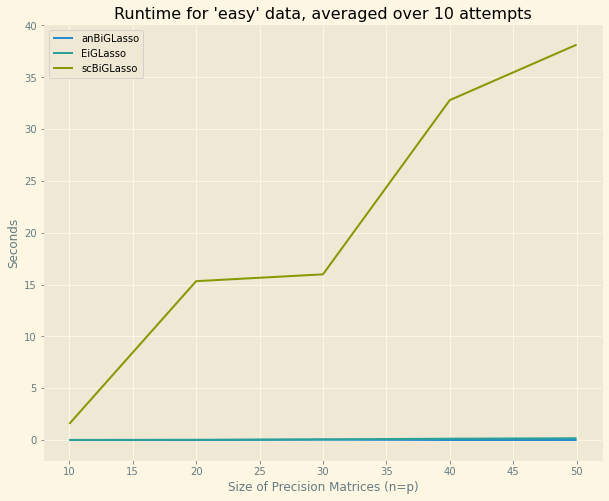

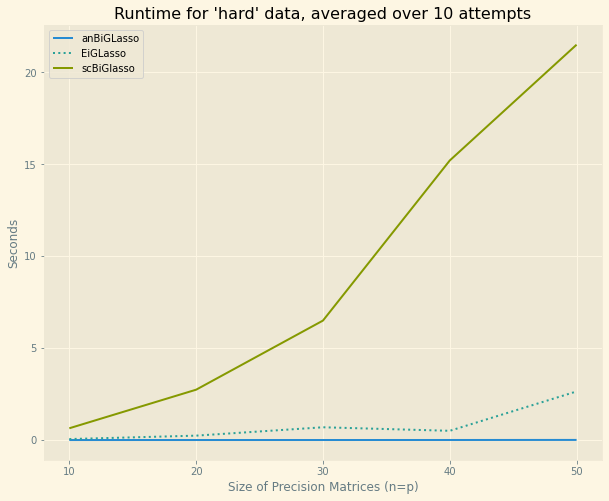

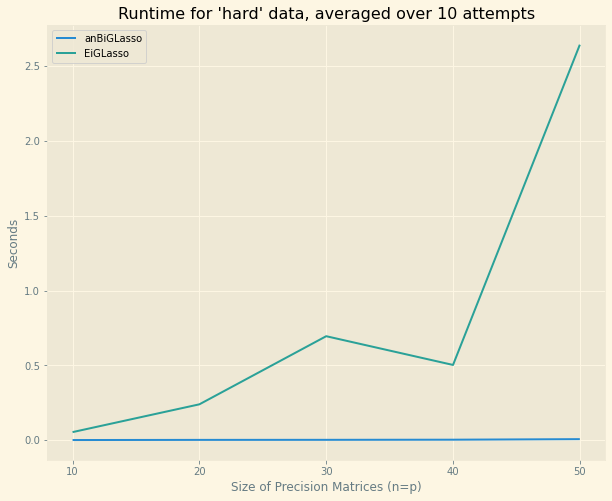

In [11]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.plot(sizes_for_easy, sc_easy, label='scBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Small Sample')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.plot(sizes_for_hard, sc_hard, label='scBiGlasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_xticks([10, 20, 30, 40, 50])
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Small Sample')
        fig3, ax3 = plt.subplots(figsize=(10, 8))
        ax3.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax3.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_xticks([10, 20, 30, 40, 50])
        ax3.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax3.legend()
        fig3.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data No scBiGLasso Small Sample'
        )

### Small Sample, just an and eig

In [12]:
attempts = 10
print("Times on an 'easy' distribution")
sizes_for_easy = [50, 100, 150, 200, 250, 300]
an_easy, eig_easy = generate_timing_graph(
    sizes_for_easy,
    attempts,
    df_scale=10,
    m=1,
    verbose=True,
    include_sc=False
)
print("Times on a 'hard' distribution")
sizes_for_hard = [50, 100, 150, 200, 250, 300]
an_hard, eig_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True,
    include_sc=False
)

Times on an 'easy' distribution
Starting size=50
	An : 0.007248370799970871 Seconds
	Eig: 0.17567044999996143 Seconds
Starting size=100
	An : 0.02143512919992645 Seconds
	Eig: 0.7391165417000594 Seconds
Starting size=150
	An : 0.03504637500000172 Seconds
	Eig: 2.0566682458000285 Seconds
Starting size=200
	An : 0.048259891699945004 Seconds
	Eig: 4.007336945899988 Seconds
Starting size=250
	An : 0.07487656250004875 Seconds
	Eig: 8.19794692080004 Seconds
Starting size=300
	An : 0.09848439999996117 Seconds
	Eig: 12.843715075 Seconds
Times on a 'hard' distribution
Starting size=50
	An : 0.008451520899961906 Seconds
	Eig: 5.568464370899983 Seconds
Starting size=100
	An : 0.026191437499983296 Seconds
	Eig: 19.80666364580002 Seconds
Starting size=150
	An : 0.03610687919999691 Seconds
	Eig: 11.592113604199948 Seconds
Starting size=200
	An : 0.05602634159995432 Seconds
	Eig: 23.048807170800046 Seconds
Starting size=250
	An : 0.07719190840007287 Seconds
	Eig: 29.435861616700002 Seconds
Starting s

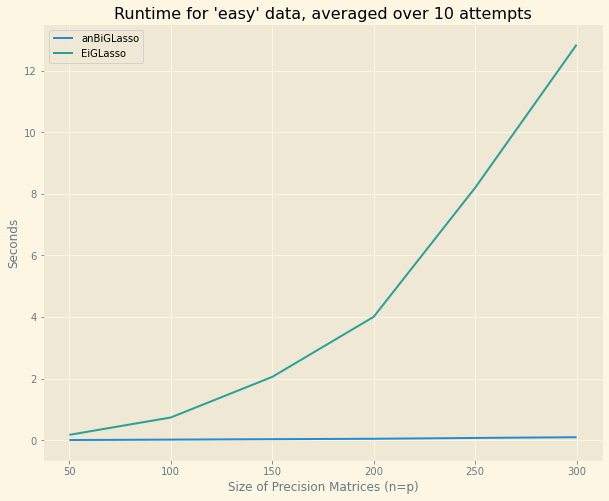

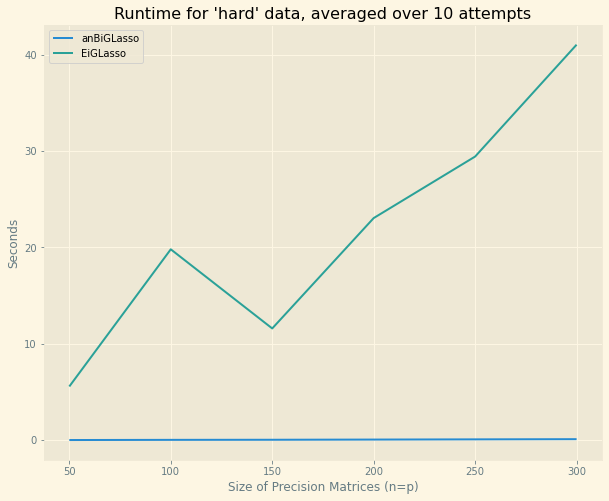

In [13]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_easy, an_easy, label='anBiGLasso')
        ax1.plot(sizes_for_easy, eig_easy, label='EiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'easy' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Easy Data Small Sample No sc')
        fig2, ax2 = plt.subplots(figsize=(10, 8))
        ax2.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax2.plot(sizes_for_hard, eig_hard, label='EiGLasso')
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax2.legend()
        fig2.savefig(f'../../Plots/Runtimes Comparison/Compare Runtimes Hard Data Small Sample No sc')

# Just anBiGLasso, very large data

In [14]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a 'hard' distribution")
sizes_for_hard = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]
an_hard = generate_timing_graph(
    sizes_for_hard,
    attempts,
    df_scale=1,
    m=1,
    verbose=True,
    include_sc=False,
    include_eig=False
)

Times on a 'hard' distribution
Starting size=500
	An : 0.2790525840000555 Seconds
Starting size=1000
	An : 1.1452061660002073 Seconds
Starting size=1500
	An : 2.836115250000148 Seconds
Starting size=2000
	An : 5.657763375000286 Seconds
Starting size=2500
	An : 9.78704737499993 Seconds
Starting size=3000
	An : 15.442992834000506 Seconds
Starting size=3500
	An : 23.88409941700047 Seconds
Starting size=4000
	An : 33.98595424999985 Seconds
Starting size=4500
	An : 47.45029629200053 Seconds
Starting size=5000
	An : 62.716043291999995 Seconds


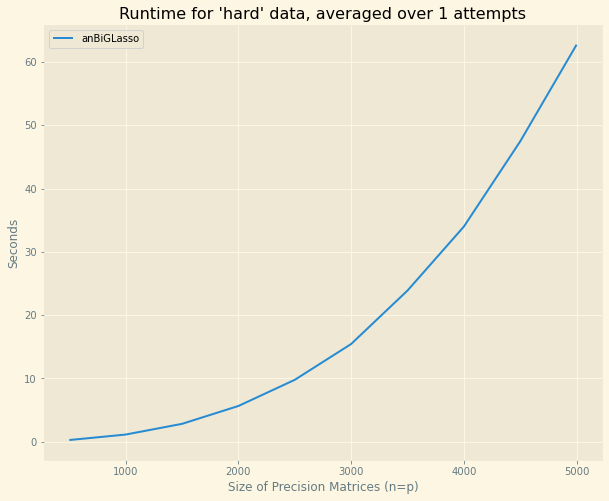

In [15]:
with plt.style.context('Solarize_Light2'):
        fig1, ax1 = plt.subplots(figsize=(10, 8))
        ax1.plot(sizes_for_hard, an_hard, label='anBiGLasso')
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for 'hard' data, averaged over {attempts} attempts")
        ax1.legend()
        fig1.savefig(
            f'../../Plots/Runtimes Comparison/Compare Runtimes Small Sample Just anBiGLasso'
        )

# All Together

In [22]:
def generate_timing_graph_smart(
    sizes,
    attempts, 
    m,
    df_scale,
    cutoff: "Amount of seconds before we stop considering it"=60,
    verbose=False
):
    include_sc = True
    include_eig = True
    include_an = True
    include_tera = True
    include_ant = True
    times_sc = []
    times_eig = []
    times_an = []
    times_tera = []
    times_ant = []
    for size in sizes:
        if not include_sc and not include_eig and not include_tera:
            # No need to do multiple attempts for
            # the non-iterative antGLasso algorithms
            attempts=1
        if verbose:
            print(f"Starting {size=}")
        if include_sc:
            times_sc.append(0)
        if include_an:
            times_an.append(0)
        if include_eig:
            times_eig.append(0)
        if include_tera:
            times_tera.append(0)
        if include_ant:
            times_ant.append(0)
        _, _, Ys = generate_Ys(
            m=m,
            n=(n:=size),
            p=(p:=size),
            expected_nonzero_psi=n**2 / 5,
            expected_nonzero_theta=p**2 / 5,
            structure="Kronecker Sum",
            df_scale=df_scale
        )
        def time_scBiGLasso():
            scBiGLasso(
                N = 100,
                eps = 10e-4,
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                verbose = False
            )
        def time_anBiGLasso():
            anBiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01,
                B_approx_iters = 10
            )
        def time_EiGLasso():
            EiGLasso(
                Ys = Ys,
                beta_1 = 0.01,
                beta_2 = 0.01
            )
        def time_TeraLasso():
            TeraLasso(
                Ys,
                np.array(
                    [0.01, 0.01],
                    dtype=np.float64
                )
            )
        def time_antGLasso():
            antGLasso(
                Ys = Ys,
                betas = [0.01, 0.01],
                B_approx_iters = 10
            )
        if include_sc:
            timer = timeit.Timer(time_scBiGLasso)
            times_sc[-1] = timer.timeit(attempts) / attempts
            if times_sc[-1] >= cutoff:
                include_sc = False
        if include_an:
            timer = timeit.Timer(time_anBiGLasso)
            times_an[-1] = timer.timeit(attempts) / attempts
            if times_an[-1] >= cutoff:
                include_an = False
        if include_eig:
            timer = timeit.Timer(time_EiGLasso)
            times_eig[-1] = timer.timeit(attempts) / attempts
            if times_eig[-1] >= cutoff:
                include_eig = False
        if include_tera:
            timer = timeit.Timer(time_TeraLasso)
            times_tera[-1] = timer.timeit(attempts) / attempts
            if times_tera[-1] >= cutoff:
                include_tera = False
        if include_ant:
            timer = timeit.Timer(time_antGLasso)
            times_ant[-1] = timer.timeit(attempts) / attempts
            if times_ant[-1] >= cutoff:
                include_ant = False
        if verbose:
            print(
                (f"\n\tSc : {times_sc[-1]} Seconds" if include_sc else "")
                + (f"\n\tAn: {times_an[-1]} Seconds" if include_an else "")
                + (f"\n\tAnt: {times_ant[-1]} Seconds" if include_ant else "")
                + (f"\n\tEig : {times_eig[-1]} Seconds" if include_eig else "")
                + (f"\n\tTera : {times_tera[-1]} Seconds" if include_tera else "")
            )
    print("Done")
    return times_sc, times_an, times_ant, times_eig, times_tera

In [17]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'hard' distribution")
sizes_for_hard_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500,
    600, 700, 800, 900, 1000,
    1250, 1500, 1750, 2000,
    2500, 3000, 3500, 4000,
    4500, 5000, 5500, 6000
]
sc_hard_small, an_hard_small, ant_hard_small, eig_hard_small, tera_hard_small = \
    generate_timing_graph_smart(
        sizes_for_hard_small,
        attempts,
        df_scale=1,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'hard' distribution
Starting size=20

	Sc : 2.396676958014723 Seconds
	An: 0.0015339580131694674 Seconds
	Ant: 0.006536290980875492 Seconds
	Eig : 0.2129782079719007 Seconds
	Tera : 0.17092900001443923 Seconds
Starting size=40

	Sc : 14.564839042024687 Seconds
	An: 0.003492791031021625 Seconds
	Ant: 0.007717916974797845 Seconds
	Eig : 8.188386375026312 Seconds
	Tera : 0.670816333964467 Seconds
Starting size=60

	Sc : 36.282314917014446 Seconds
	An: 0.00919737498043105 Seconds
	Ant: 0.010502666991669685 Seconds
	Eig : 6.601326791977044 Seconds
	Tera : 0.8424623750033788 Seconds
Starting size=80

	An: 0.012378916959278286 Seconds
	Ant: 0.02037354197818786 Seconds
	Eig : 4.918367000005674 Seconds
	Tera : 1.6696056249784306 Seconds
Starting size=100

	An: 0.022244166990276426 Seconds
	Ant: 0.0207931250333786 Seconds
	Eig : 6.391648542019539 Seconds
	Tera : 4.610862625006121 Seconds
Starting size=125

	An: 0.03662891697604209 Seconds
	Ant: 0.027599541994277388 Second

In [19]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'easy' distribution")
sizes_for_easy_small = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500,
    600, 700, 800, 900, 1000,
    1250, 1500, 1750, 2000,
    2500, 3000, 3500, 4000,
    4500, 5000, 5500, 6000
]
sc_easy_small, an_easy_small, ant_easy_small, eig_easy_small, tera_easy_small = \
    generate_timing_graph_smart(
        sizes_for_easy_small,
        attempts,
        df_scale=2,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'easy' distribution
Starting size=20

	Sc : 4.941907832981087 Seconds
	An: 0.0017463329713791609 Seconds
	Ant: 0.0034452080144546926 Seconds
	Eig : 0.05320445797406137 Seconds
	Tera : 0.2963044160278514 Seconds
Starting size=40

	Sc : 24.7828173750313 Seconds
	An: 0.0076469999621622264 Seconds
	Ant: 0.010178124997764826 Seconds
	Eig : 0.5299862920073792 Seconds
	Tera : 0.3821322090225294 Seconds
Starting size=60

	An: 0.008290124998893589 Seconds
	Ant: 0.013452208018861711 Seconds
	Eig : 0.48964524996699765 Seconds
	Tera : 0.8982329170103185 Seconds
Starting size=80

	An: 0.019019707979168743 Seconds
	Ant: 0.01632683299249038 Seconds
	Eig : 0.5181839999859221 Seconds
	Tera : 1.583931749977637 Seconds
Starting size=100

	An: 0.022761750034987926 Seconds
	Ant: 0.02081766602350399 Seconds
	Eig : 0.9042066669790074 Seconds
	Tera : 2.180278666957747 Seconds
Starting size=125

	An: 0.034699459036346525 Seconds
	Ant: 0.030007666035089642 Seconds
	Eig : 1.62049895798554

In [20]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a large-sample 'hard' distribution")
sizes_for_hard_large = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500
]
sc_hard_large, an_hard_large, ant_hard_large, eig_hard_large, tera_hard_large = \
    generate_timing_graph_smart(
        sizes_for_hard_large,
        attempts,
        df_scale=1,
        m=100,
        cutoff=60,
        verbose=True
    )

Times on a large-sample 'hard' distribution
Starting size=20

	Sc : 4.353595458029304 Seconds
	An: 0.003907041042111814 Seconds
	Ant: 0.004662583000026643 Seconds
	Eig : 0.1425630830344744 Seconds
	Tera : 0.4124617089983076 Seconds
Starting size=40

	Sc : 23.28700025001308 Seconds
	An: 0.007735666004009545 Seconds
	Ant: 0.010002915980294347 Seconds
	Eig : 0.0356995000038296 Seconds
	Tera : 0.3854630420100875 Seconds
Starting size=60

	An: 0.019263082998804748 Seconds
	Ant: 0.023761624994222075 Seconds
	Eig : 0.11515187501208857 Seconds
	Tera : 0.8977721669944003 Seconds
Starting size=80

	An: 0.060345000005327165 Seconds
	Ant: 0.09145995799917728 Seconds
	Eig : 0.234271458000876 Seconds
	Tera : 1.545162790978793 Seconds
Starting size=100

	An: 0.1092592499917373 Seconds
	Ant: 0.09257258399156854 Seconds
	Eig : 0.3687599169788882 Seconds
	Tera : 2.8683002500329167 Seconds
Starting size=125

	An: 0.11078400001861155 Seconds
	Ant: 0.09382308297790587 Seconds
	Eig : 0.5487419170094654 Seco

In [21]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a large-sample 'easy' distribution")
sizes_for_easy_large = [
    20, 40, 60, 80, 100,
    125, 150, 175, 200,
    250, 300, 350, 400, 450, 500
]
sc_easy_large, an_easy_large, ant_easy_large, eig_easy_large, tera_easy_large = \
    generate_timing_graph_smart(
        sizes_for_easy_large,
        attempts,
        df_scale=2,
        m=100,
        cutoff=60,
        verbose=True
    )

Times on a large-sample 'easy' distribution
Starting size=20

	Sc : 0.11486091703409329 Seconds
	An: 0.002665167034137994 Seconds
	Ant: 0.0052969169919379056 Seconds
	Eig : 0.007443915994372219 Seconds
	Tera : 0.03664287499850616 Seconds
Starting size=40

	Sc : 0.3418864589766599 Seconds
	An: 0.006089875008910894 Seconds
	Ant: 0.008713708026334643 Seconds
	Eig : 0.016066000040154904 Seconds
	Tera : 0.09679137502098456 Seconds
Starting size=60

	Sc : 0.31462408299557865 Seconds
	An: 0.015725291974376887 Seconds
	Ant: 0.017492290993686765 Seconds
	Eig : 0.04099541698815301 Seconds
	Tera : 0.2044210000312887 Seconds
Starting size=80

	Sc : 0.5550191670190543 Seconds
	An: 0.03217800002312288 Seconds
	Ant: 0.041608541971072555 Seconds
	Eig : 0.07002679200377315 Seconds
	Tera : 0.34696391702163965 Seconds
Starting size=100

	Sc : 1.6734837080002762 Seconds
	An: 0.11613554100040346 Seconds
	Ant: 0.05958754202583805 Seconds
	Eig : 0.25545925000915304 Seconds
	Tera : 0.6188104589818977 Seconds


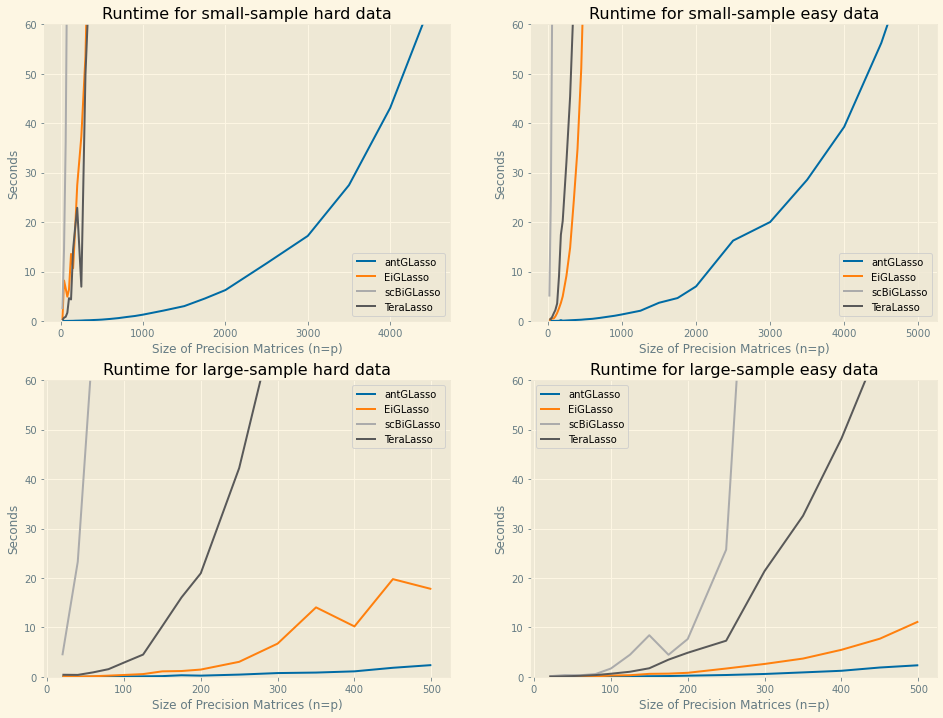

In [81]:
with plt.style.context('Solarize_Light2'):
        plt.rcParams['axes.prop_cycle'] = cycler(color=[
            '#006BA4',
            '#FF800E',
            '#ABABAB',
            '#595959',
            '#5F9ED1',
            '#C85200',
            '#898989',
            '#A2C8EC',
            '#FFBC79',
            '#CFCFCF'
        ])
        fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(16, 12), nrows=2, ncols=2)
        ax1.plot(
            sizes_for_hard_small[:len(ant_hard_small)],
            ant_hard_small,
            label='antGLasso'
        )
        ax1.plot(
            sizes_for_hard_small[:len(eig_hard_small)],
            eig_hard_small,
            label='EiGLasso'
        )
        ax1.plot(sizes_for_hard_small[:len(sc_hard_small)],
                 sc_hard_small,
                 label='scBiGLasso'
        )
        ax1.plot(sizes_for_hard_small[:len(tera_hard_small)],
                 tera_hard_small,
                 label='TeraLasso'
        )
        ax1.set_xlabel("Size of Precision Matrices (n=p)")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for small-sample hard data")
        ax1.set_ylim([0, 60])
        ax1.legend()
        
        ax2.plot(
            sizes_for_easy_small[:len(ant_easy_small)],
            ant_easy_small,
            label='antGLasso'
        )
        ax2.plot(
            sizes_for_easy_small[:len(eig_easy_small)],
            eig_easy_small,
            label='EiGLasso'
        )
        ax2.plot(sizes_for_easy_small[:len(sc_easy_small)],
                 sc_easy_small,
                 label='scBiGLasso'
        )
        ax2.plot(sizes_for_easy_small[:len(tera_easy_small)],
                 tera_easy_small,
                 label='TeraLasso'
        )
        ax2.set_xlabel("Size of Precision Matrices (n=p)")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for small-sample easy data")
        ax2.set_ylim([0, 60])
        ax2.legend()
        
        ax3.plot(
            sizes_for_hard_large[:len(ant_hard_large)],
            ant_hard_large,
            label='antGLasso'
        )
        ax3.plot(
            sizes_for_hard_large[:len(eig_hard_large)],
            eig_hard_large,
            label='EiGLasso'
        )
        ax3.plot(sizes_for_hard_large[:len(sc_hard_large)],
                 sc_hard_large,
                 label='scBiGLasso'
        )
        ax3.plot(sizes_for_hard_large[:len(tera_hard_large)],
                 tera_hard_large,
                 label='TeraLasso'
        )
        ax3.set_xlabel("Size of Precision Matrices (n=p)")
        ax3.set_ylabel("Seconds")
        ax3.set_title(f"Runtime for large-sample hard data")
        ax3.set_ylim([0, 60])
        ax3.legend()
        
        ax4.plot(
            sizes_for_easy_large[:len(ant_easy_large)],
            ant_easy_large,
            label='antGLasso'
        )
        ax4.plot(
            sizes_for_easy_large[:len(eig_easy_large)],
            eig_easy_large,
            label='EiGLasso'
        )
        ax4.plot(sizes_for_easy_large[:len(sc_easy_large)],
                 sc_easy_large,
                 label='scBiGLasso'
        )
        ax4.plot(sizes_for_easy_large[:len(tera_easy_large)],
                 tera_easy_large,
                 label='TeraLasso'
        )
        ax4.set_xlabel("Size of Precision Matrices (n=p)")
        ax4.set_ylabel("Seconds")
        ax4.set_title(f"Runtime for large-sample easy data")
        ax4.set_ylim([0, 60])
        ax4.legend()
        
        fig1.savefig(f'../../Plots/Runtimes Comparison/All Together')

# Tensors 

In [73]:
def generate_timing_graph_tensor(
    sizes,
    attempts, 
    m,
    df_scale,
    num_dims,
    cutoff: "Amount of seconds before we stop considering it"=60,
    verbose=False,
):
    include_tera = True
    include_ant = True
    times_tera = []
    times_ant = []
    for size in sizes:
        if not include_tera:
            # No need to do multiple attempts for
            # the non-iterative antGLasso algorithms
            attempts=1
        if verbose:
            print(f"Starting {size=}")
        if include_tera:
            times_tera.append(0)
        if include_ant:
            times_ant.append(0)
        _, Ys = generate_Ys(
            m=m,
            ds=(ds:=[size]*num_dims),
            expected_nonzero=size**2 / 5,
            df_scale=df_scale
        )
        def time_TeraLasso():
            TeraLasso(
                Ys,
                np.array(
                    [0.01]*num_dims,
                    dtype=np.float64
                )
            )
        def time_antGLasso():
            antGLasso(
                Ys = Ys,
                betas = [0.01]*num_dims,
                B_approx_iters = 10
            )
        if include_tera:
            timer = timeit.Timer(time_TeraLasso)
            times_tera[-1] = timer.timeit(attempts) / attempts
            if times_tera[-1] >= cutoff:
                include_tera = False
        if include_ant:
            timer = timeit.Timer(time_antGLasso)
            times_ant[-1] = timer.timeit(attempts) / attempts
            if times_ant[-1] >= cutoff:
                include_ant = False
        if verbose:
            print(
                (f"\n\tAnt: {times_ant[-1]} Seconds" if include_ant else "")
                + (f"\n\tTera : {times_tera[-1]} Seconds" if include_tera else "")
            )
    print("Done")
    return times_ant, times_tera

In [78]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'hard' distribution")
sizes_for_hard_small_tensor = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200,
    220, 240, 260, 280, 300
]
ant_hard_small_tensor, tera_hard_small_tensor = \
    generate_timing_graph_tensor(
        sizes_for_hard_small_tensor,
        attempts,
        num_dims=3,
        df_scale=1,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'hard' distribution
Starting size=20

	Ant: 0.017649916000664234 Seconds
	Tera : 0.8020575839909725 Seconds
Starting size=40

	Ant: 0.021149082982447 Seconds
	Tera : 2.1478696249541827 Seconds
Starting size=60

	Ant: 0.043778999999631196 Seconds
	Tera : 2.0172529999981634 Seconds
Starting size=80

	Ant: 0.17360783298499882 Seconds
	Tera : 3.856537958025001 Seconds
Starting size=100

	Ant: 0.3863877920084633 Seconds
	Tera : 5.298853708023671 Seconds
Starting size=120

	Ant: 0.44166875001974404 Seconds
	Tera : 8.546860540984198 Seconds
Starting size=140

	Ant: 0.6366698750061914 Seconds
	Tera : 11.32440470799338 Seconds
Starting size=160

	Ant: 3.9161829170188867 Seconds
	Tera : 31.590551458997652 Seconds
Starting size=180

	Ant: 2.0701847919845022 Seconds
	Tera : 31.372170707967598 Seconds
Starting size=200

	Ant: 2.8990500000072643 Seconds
Starting size=220

	Ant: 4.123403125035111 Seconds
Starting size=240

	Ant: 5.473643457982689 Seconds
Starting size=260

	An

In [79]:
attempts = 1
# Note that 'easy'/'hard' will be the same for non-iterative algorithms
print("Times on a small-sample 'easy' distribution")
sizes_for_easy_small_tensor = [
    20, 40, 60, 80, 100, 120, 140, 160, 180, 200,
    220, 240, 260, 280, 300
]
ant_easy_small_tensor, tera_easy_small_tensor = \
    generate_timing_graph_tensor(
        sizes_for_easy_small_tensor,
        attempts,
        num_dims=3,
        df_scale=2,
        m=1,
        cutoff=60,
        verbose=True
    )

Times on a small-sample 'easy' distribution
Starting size=20

	Ant: 0.007012957998085767 Seconds
	Tera : 0.16207674995530397 Seconds
Starting size=40

	Ant: 0.012812416011001915 Seconds
	Tera : 0.27970095799537376 Seconds
Starting size=60

	Ant: 0.030083167017437518 Seconds
	Tera : 0.5242046670173295 Seconds
Starting size=80

	Ant: 0.15514799999073148 Seconds
	Tera : 0.9169336250051856 Seconds
Starting size=100

	Ant: 0.378046625002753 Seconds
	Tera : 1.381309208984021 Seconds
Starting size=120

	Ant: 0.3344960000249557 Seconds
	Tera : 1.9201658749952912 Seconds
Starting size=140

	Ant: 0.6027889999677427 Seconds
	Tera : 2.8974707500310615 Seconds
Starting size=160

	Ant: 3.5519342909683473 Seconds
	Tera : 4.665991124988068 Seconds
Starting size=180

	Ant: 1.8110849580261856 Seconds
	Tera : 6.9625124169979244 Seconds
Starting size=200

	Ant: 2.637633415986784 Seconds
	Tera : 8.917143500002567 Seconds
Starting size=220

	Ant: 4.008394124975894 Seconds
	Tera : 11.3150983749656 Seconds
St

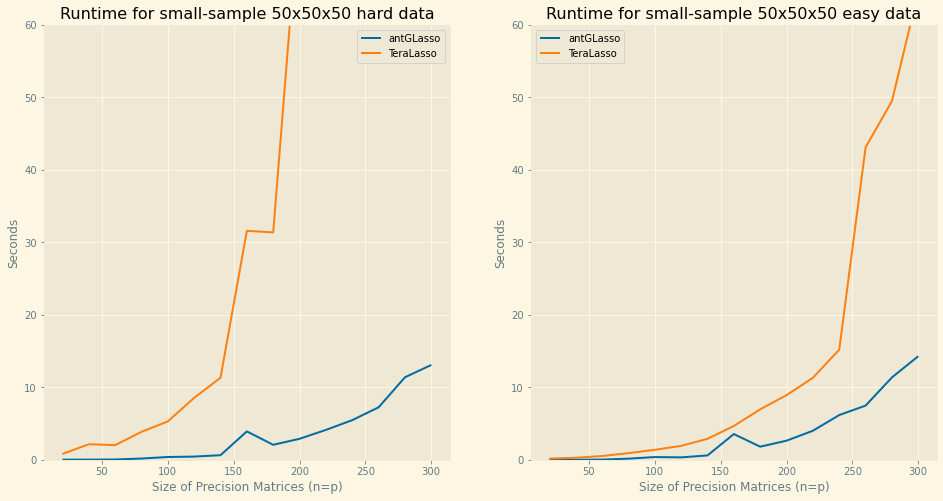

In [87]:
with plt.style.context('Solarize_Light2'):
        plt.rcParams['axes.prop_cycle'] = cycler(color=[
            '#006BA4',
            '#FF800E',
            '#ABABAB',
            '#595959',
            '#5F9ED1',
            '#C85200',
            '#898989',
            '#A2C8EC',
            '#FFBC79',
            '#CFCFCF'
        ])
        fig1, (ax1, ax2) = plt.subplots(figsize=(16, 8), ncols=2)
        ax1.plot(
            sizes_for_hard_small_tensor[:len(ant_hard_small_tensor)],
            ant_hard_small_tensor,
            label='antGLasso'
        )
        ax1.plot(sizes_for_hard_small_tensor[:len(tera_hard_small_tensor)],
                 tera_hard_small_tensor,
                 label='TeraLasso'
        )
        ax1.set_xlabel("Size of Precision Matrices")
        ax1.set_ylabel("Seconds")
        ax1.set_title(f"Runtime for small-sample [n] hard data")
        ax1.set_ylim([0, 60])
        ax1.legend()
        
        ax2.plot(
            sizes_for_easy_small_tensor[:len(ant_easy_small_tensor)],
            ant_easy_small_tensor,
            label='antGLasso'
        )
        ax2.plot(sizes_for_easy_small_tensor[:len(tera_easy_small_tensor)],
                 tera_easy_small_tensor,
                 label='TeraLasso'
        )
        ax2.set_xlabel("Size of Precision Matrices")
        ax2.set_ylabel("Seconds")
        ax2.set_title(f"Runtime for small-sample [nxnxn] easy data")
        ax2.set_ylim([0, 60])
        ax2.legend()
        
        fig1.savefig(f'../../Plots/Runtimes Comparison/All Together Tensors')

# Old Fashioned Runtime Calculations

In [39]:
# Time to generate data
from Scripts.generate_data import generate_Ys, fast_tensor_normal_ks
kwargs_gen = {
    'm': 10,
    'ds': (ds:=[50, 50, 50]),
    'expected_nonzero': ds[0]**2 / 5,
}
%lprun -f generate_Ys -f fast_tensor_normal_ks (Ys:=generate_Ys(**kwargs_gen)[1])

In [63]:
from Scripts.antGLasso import calculateEigenvalues, eigenvalues_MLE, antGLasso
from Scripts.antGLasso import eigenvectors_MLE, rescaleYs, nmode_gram
kwargs = {
    "Ys": Ys,
    "betas": [0.1, 0.1]
}
%lprun \
    -f antGLasso \
    -f eigenvectors_MLE \
    -f eigenvalues_MLE \
    -f calculateEigenvalues \
    -f rescaleYs \
    -f nmode_gram \
    antGLasso(**kwargs)